In [ ]:
from google.colab import drive
import os

drive.mount('drive')
path = 'drive/MyDrive/iprofi_ml'
os.chdir(path)

Mounted at drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from xgboost import XGBRegressor

## Task 1



В базе данных нефтегазовых месторождений одной компании произошёл системный сбой и информация о типе месторождения по расположению (на берегу или в открытом море) была удалена. Так как эта информация крайне важна, вам необходимо восстановить её в пострадавшем датасете (https://yadi.sk/d/oTXS7UAIu2OJOg).

В качестве тренировочного датасета можете использовать неиспорченный датасет (https://yadi.sk/d/MmT-_fY6sKzlTmw).

Входные данные: тренировочный датасет train.csv, в котором поля обозначают следующее:

* Tectonic regime – тектонический режим месторождения
* Onshore/Oﬀshore – тип месторождения по расположению
* Hydrocarbon type – тип углеводородов
* Reservoir status – статус разработки месторождения
* Structural setting – структурные особенности месторождения
* Depth – средняя глубина кровли резервуара
* Period – геологическая система образования резервуара
* Lithology – основной литологический состав коллектора
* Gross – среднее значение общей толщины резервуара
* Netpay – среднее значение эффективной углеводородонасыщенной толщины * коллектора
* Porosity – среднее значение матричной пористости
* Permeability – среднее значение проницаемости по воздуху.

test.csv – датасет, для которого необходимо предсказать поле «Onshore/Oﬀshore»

Выходные данные: файл prediction.csv, в котором одна колонка (без заголовка) с предсказанием поля Onshore/Oﬀshore. Предсказания следует выводить в тех же значениях, в каких они представлены в тренировочном датасете (ONSHORE/OFFSHORE/ ONSHORE-OFFSHORE).

Критерии проверки: вычисляется точность предсказания (accuracy_score), округляется до 2-х знаков и итоговый балл считается по формуле score = 50*accuracy_score. Таким образом максимальный балл 50 будет соответствовать максимально точности 1.

У вас есть 10 попыток на отправку ответа. Учитывается лучшая посылка

In [ ]:
os.chdir('task 1')

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
categorical = ['Tectonic regime', 'Hydrocarbon type', 'Reservoir status', 'Structural setting', 
                        'Period', 'Lithology']
numerical = ['Depth', 'Gross', 'Netpay', 'Porosity', 'Permeability']
target = 'Onshore/Offshore'

### EDA

In [ ]:
train

,Tectonic regime,Onshore/Offshore,Hydrocarbon type,Reservoir status,Structural setting,Depth,Period,Lithology,Gross,Netpay,Porosity,Permeability
0,STRIKE-SLIP/TRANSPRESSION/BASEMENT-I,OFFSHORE,OIL,DEVELOPING,INVERSION/WRENCH,3520,NEOGENE,SANDSTONE,2460.0,220.0,20.0,45.0
1,GRAVITY/EXTENSION/EVAPORITE,OFFSHORE,OIL,MATURE PRODUCTION,SALT/PASSIVE MARGIN,9967,CRETACEOUS,LIMESTONE,427.0,160.0,19.0,175.0
2,GRAVITY/EXTENSION/EVAPORITE,ONSHORE,OIL,MATURE PRODUCTION,PASSIVE MARGIN,8700,CRETACEOUS,LIMESTONE,95.0,15.0,12.0,20.0
3,COMPRESSION,ONSHORE,OIL,DECLINING PRODUCTION,THRUST,5084,CRETACEOUS,SANDSTONE,328.0,300.0,13.0,600.0
4,INVERSION/COMPRESSION/EXTENSION,ONSHORE,OIL,DECLINING PRODUCTION,INVERSION/RIFT,1030,CRETACEOUS,SANDSTONE,260.0,33.0,24.0,182.0
...,...,...,...,...,...,...,...,...,...,...,...,...
304,GRAVITY/EXTENSION/EVAPORITE/SYNSEDIMENTATION,OFFSHORE,OIL,DECLINING PRODUCTION,DELTA/SUB-SALT/PASSIVE MARGIN,13265,NEOGENE,LOW-RESISTIVITY SANDSTONE,1500.0,295.0,29.0,1500.0
305,INVERSION/COMPRESSION/EXTENSION,OFFSHORE,OIL,DECLINING PRODUCTION,RIFT/PASSIVE MARGIN,1657,CRETACEOUS,LOW-RESISTIVITY SANDSTONE,164.0,98.0,32.0,7500.0
306,COMPRESSION/EVAPORITE,ONSHORE,OIL,CONTINUING DEVELOPMENT,FORELAND,10211,CRETACEOUS,CHALKY LIMESTONE,328.0,213.0,13.0,0.8
307,INVERSION/COMPRESSION/EXTENSION/EVAPORITE,OFFSHORE,GAS-CONDENSATE,PLATEAU PRODUCTION,SALT/RIFT,16360,JURASSIC,SANDSTONE,980.0,490.0,16.0,10.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Tectonic regime     309 non-null    object 
 1   Onshore/Offshore    309 non-null    object 
 2   Hydrocarbon type    309 non-null    object 
 3   Reservoir status    309 non-null    object 
 4   Structural setting  309 non-null    object 
 5   Depth               309 non-null    int64  
 6   Period              309 non-null    object 
 7   Lithology           309 non-null    object 
 8   Gross               309 non-null    float64
 9   Netpay              309 non-null    float64
 10  Porosity            309 non-null    float64
 11  Permeability        309 non-null    float64
dtypes: float64(4), int64(1), object(7)
memory usage: 29.1+ KB


In [ ]:
train[categorical].nunique()

Tectonic regime       56
Hydrocarbon type       5
Reservoir status      12
Structural setting    48
Period                22
Lithology             16
dtype: int64

(array([ 93.,   0.,   0.,   0.,   0., 211.,   0.,   0.,   0.,   5.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

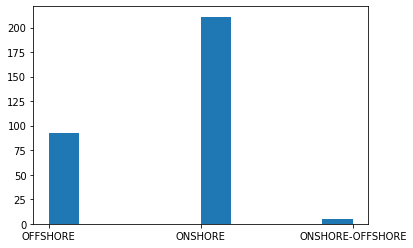

In [ ]:
plt.hist(train[target])

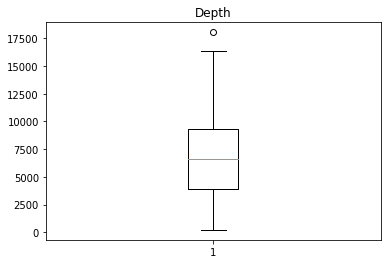

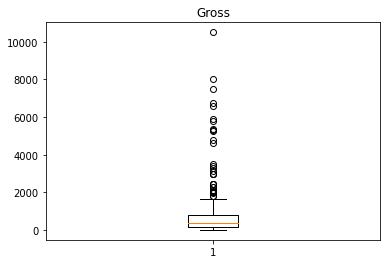

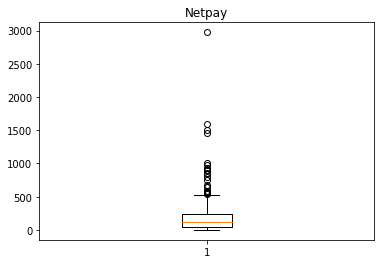

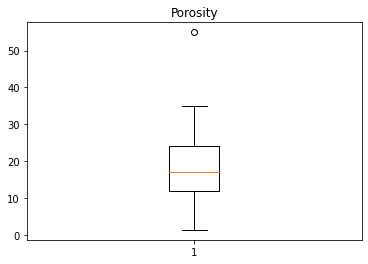

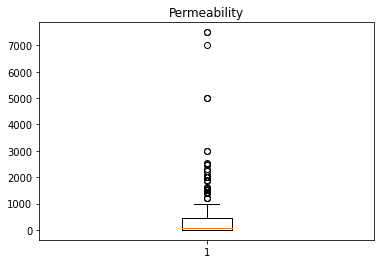

In [ ]:
for i in numerical:
  plt.boxplot(train[i])
  plt.title(i)
  plt.show()

### Feature enginering

In [ ]:
def unique_struct(train, column):
  struct = train.iloc[0][column]
  for i in range(1, train.shape[0]):
    struct = struct + '/' + train.iloc[i][column]

  struct = struct.split('/')

  struct_set = list(set(struct))
  return struct_set

def get_struct(train, struct_set, column):
  for i in struct_set:
    if i != '':
      lst = []
      for j in range(train.shape[0]):
        if i in train.iloc[j][column]:
          lst.append(1)
        else:
          lst.append(0)
      train[i] = lst
  return train

def pipeline(train, struct_set, period_set, lit_set):
  train = get_struct(train, struct_set, 'Structural setting')
  train = get_struct(train, period_set, 'Period')
  train = get_struct(train, lit_set, 'Lithology')

  # train = pd.concat([train, pd.get_dummies(train['Hydrocarbon type'])], axis=1)
  # tect_set = unique_struct(train, 'Tectonic regime')
  # train = get_struct(train, tect_set, 'Tectonic regime')

  return train

#struct_set = unique_struct(test, 'Structural setting')
#period_set = unique_struct(test, 'Period')
#lit_set = unique_struct(test, 'Lithology')

#train = pipeline(train, struct_set, period_set, lit_set)
#test = pipeline(test, struct_set, period_set, lit_set)
#train = pd.concat([train, pd.get_dummies(train[categorical])], axis=1)

In [ ]:
t = train[target]
df = pd.concat([train.drop(target, axis=1), test], axis=0)
df = pd.get_dummies(df)

### Model

In [ ]:
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=1,
              learning_rate=0.02, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

results = cross_val_score(model, df[:-133], train[target], cv=5)
results.mean()

0.7313915857605178

In [ ]:
folds = 3
param_comb = 5

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

model = XGBClassifier(learning_rate=0.02)

random_search = RandomizedSearchCV(model,
                                   param_distributions=params,
                                   n_iter=param_comb,
                                   scoring='accuracy',
                                   cv=folds,
                                   random_state=1001)

In [ ]:
random_search.fit(df[:-133], train[target])

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.02, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, s...ht=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated'

In [ ]:
model = XGBClassifier()
model.fit(df[:-133], train[target])
prediction = model.predict(df[-133:])
prediction = pd.Series(prediction)

In [ ]:
prediction.to_csv('prediction.csv', index=False, header=None)

In [ ]:
t = pd.read_csv('prediction.csv')
t

,ONSHORE
0,ONSHORE
1,ONSHORE
2,OFFSHORE
3,ONSHORE
4,OFFSHORE
...,...
127,OFFSHORE
128,ONSHORE
129,ONSHORE
130,ONSHORE


## Task 2



Из-за сильнейшего ливня в лаборатории квантовой механики произошёл потоп, вследствие чего она была закрыта на срочный ремонт. Однако учёные привыкли доводить все свои дела до конца, и ждать пока закончится ремонт были не намерены. Перед ними стояла задача определить критические температуры для сверхпроводников, созданных на основе различных химических элементов. Однако никаких привычных лабораторных приспособлений для этого не имелось, существовала только информация о характеристиках каждого из сверхпроводников и химические формулы сверхпроводников, которую им подсказали ученые-химики из соседней лаборатории. В поисках решения они решили изучить новейшие технологии в области анализа данных и обнаружили, что им может помочь машинное обучение. Помогите учёным-физикам, не имеющим опыта в решении задач машинного обучения, определить критические температуры всех сверхпроводников используя их характеристики и химический состав. Для обучения моделей необходимо воспользоваться информацией о сверхпроводниках, для которых ученые успели получить критическую температуру (train.csv). Возможно сделать предсказание более эффективным вам поможет химическая формула для каждого из сверхпроводников (formula_train.csv). Целевым полем является поле critical_temperature. Ваша задача для недостающих соединений (test.csv) предсказать поле critical_temperature и в качестве ответа загрузить файл answer.csv, где будет одна колонка с предсказанием (без заголовка колонки).

Входные данные: файлы train.csv, formula_train.csv, test.csv, formula_test.csv скачать - https://yadi.sk/d/xDmCwbdN6qb1og?w=1.

Выходные данные: вам следует загрузить файл answer.csv, где будет одна колонка с предсказанием поля critical_temperature для файла test.csv (без заголовка колонки).

Критерии проверки: Для файла участника считается R_squared_score. Округляем значение R_squared_score до двух знаков, затем количество баллов считается по следующей формуле score = R_squared_score*50 если 0
≤
R_squared_score
≤
1, округляем до целого.

У вас есть 10 попыток на отправку ответа. Учитывается лучшая посылка

In [ ]:
os.chdir('task 2')

In [ ]:
os.listdir()

['test.csv',
 'formula_train.csv',
 'formula_test.csv',
 'train.csv',
 'predictions.csv']

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
lst = ['feature{}'.format(i) for i in range(2, 82) if (i != 78 and i != 28)]

In [ ]:
def linear_sum(df, columns):
  for i in columns:
    for j in columns:
      col_name = i + '+' + j
      df[col_name] = df[i] + df[j]
  return df

def mult(df, columns):
  for i in columns:
    for j in columns:
      col_name = i + '*' + j
      df[col_name] = df[i] * df[j]
  return df

def pow_col(df, columns, p=2):
  for i in columns:
    col_name = i + '^{}'.format(p)
    df[col_name] = df[i].pow(p)
  return df

In [ ]:
# train = linear_sum(train, lst) # 0.8722592783671539
# train = pow_col(train, lst) # 0.8582978240371433
train = mult(train, lst)

In [ ]:
train

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,feature40,...,feature81*feature41,feature81*feature42,feature81*feature43,feature81*feature44,feature81*feature45,feature81*feature46,feature81*feature47,feature81*feature48,feature81*feature49,feature81*feature50,feature81*feature51,feature81*feature52,feature81*feature53,feature81*feature54,feature81*feature55,feature81*feature56,feature81*feature57,feature81*feature58,feature81*feature59,feature81*feature60,feature81*feature61,feature81*feature62,feature81*feature63,feature81*feature64,feature81*feature65,feature81*feature66,feature81*feature67,feature81*feature68,feature81*feature69,feature81*feature70,feature81*feature71,feature81*feature72,feature81*feature73,feature81*feature74,feature81*feature75,feature81*feature76,feature81*feature77,feature81*feature79,feature81*feature80,feature81*feature81
0,4,95.950150,87.221940,89.534122,81.423258,1.317590,1.301059,96.119000,20.285800,36.105357,34.833271,740.625,786.620000,726.788285,771.273911,1.367745,1.202333,399.3,307.450000,142.347627,149.963748,169.750000,156.400000,164.442987,150.821660,1.355290,1.327938,117,29.000000,42.180416,43.345588,7803.750000,6938.800000,7354.256010,6686.502371,1.325027,1.325720,7126.000,1313.400000,2816.060402,...,2375.393388,71.270300,65.352877,58.914044,53.661276,1.406567,1.317102,97.222911,30.257224,36.300309,33.945138,21.721824,22.318110,19.746430,20.367625,1.475843,1.295222,20.898383,10.471907,8.827872,8.890530,74.677645,66.443228,57.646302,55.120699,1.352760,1.366818,120.392857,23.737837,44.152371,34.622717,4.827072,4.656705,4.604005,4.479800,1.521627,1.414621,1.590094,1.475424,1.290000
1,5,83.244760,59.224400,59.506081,36.126175,1.311510,1.372050,192.981000,25.192187,67.233835,64.196304,779.880,1005.866667,740.399333,945.371396,1.553219,1.019202,764.1,661.026667,276.063148,333.238432,149.800000,106.133333,133.425311,86.457339,1.519537,1.573185,171,16.266667,58.608532,66.319295,4584.285800,2953.428800,874.164786,64.622881,1.161774,1.099512,9778.571,1303.237867,4004.273231,...,4055.822143,74.547665,107.564157,33.805258,69.904791,1.224668,0.844062,141.375415,77.241987,58.787282,53.713869,8.313849,5.052516,4.738451,1.348054,1.420523,1.423456,13.133035,1.660513,4.447392,5.357448,131.152203,73.848259,14.570594,0.988349,0.889245,0.792717,407.894455,54.375085,157.057988,140.303871,2.651490,2.447529,2.449823,2.304652,1.549472,1.392111,0.951817,1.223765,1.040000
2,2,23.035850,26.647510,21.192566,25.010514,0.614232,0.435817,18.058300,18.243490,9.029150,8.275353,1200.250,1119.750000,1183.257580,1105.792837,0.679023,0.661811,402.5,278.850000,201.250000,184.448672,71.500000,77.700000,69.799713,76.228941,0.669462,0.522077,31,44.100000,15.500000,14.205985,980.625500,1372.375300,49.517270,215.653466,0.005331,0.002517,1958.749,1371.624700,979.374500,...,1234.011870,144.351134,197.417361,56.895496,107.164049,0.232962,0.122601,265.331133,190.406020,132.665566,121.590000,1.436637,1.813325,1.084939,1.485094,0.631617,0.389525,1.883439,1.516374,0.941719,0.863100,0.158669,0.207933,0.100039,0.151390,0.481817,0.277884,0.246318,0.186627,0.123159,0.112877,6.186477,7.011341,5.832667,6.699975,0.875062,0.640643,4.536750,2.062159,1.890000
3,4,81.756699,79.833804,76.282833,75.275775,1.312596,1.149324,81.482000,28.789976,32.890369,29.969284,741.475,782.600000,723.246140,763.358485,1.362746,1.059188,443.7,363.318000,157.803998,163.153443,168.750000,158.520000,161.714287,151.499174,1.342444,1.166582,139,56.240000,51.329207,50.807181,6502.750000,6162.920000,6126.394078,5912.543550,1.332169,1.068492,5390.000,2814.120000,2072.768363,...,1985.487303,53.123652,51.197602,41.047304,38.215103,1.397593,0.962725

### Model

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train.drop('critical_temperature', axis=1),
                                                    train['critical_temperature'],
                                                    random_state=42,
                                                    test_size=0.2)

model = XGBRegressor()
model.fit(x_train, y_train)
pred = model.predict(x_test)
r2_score(y_test, pred)

[18:50:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.8705031979486733

In [ ]:
50 * 0.8705031979486733

43.52515989743366

In [ ]:
final_model = XGBRegressor()
final_model.fit(train.drop('critical_temperature', axis=1),
                train['critical_temperature'])
pred = final_model.predict(test)
pred = pd.Series(pred)

[18:57:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


ValueError: ignored

In [ ]:
pred.to_csv('predictions.csv', index=False, header=None)
t = pd.read_csv('predictions.csv')
t